# SSL (Cont. from IY011)

In [1]:
import torch
import torch.optim as optim
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from dataloaders.simclr import ssl_data_prep
from dataloaders import  save_loader_to_disk
from models.ssl_transformer import SSL_Transformer
from training.train import train_ssl_model
from info_nce import InfoNCE
import wandb
%load_ext autoreload
%autoreload 2  

In [2]:
# Setup Configuration
DATA_ROOT = Path("/home/ianyang/stochastic_simulations/experiments/EXP-26-IY020/data")
RESULTS_PATH = DATA_ROOT / "IY020_simulation_parameters_sobol.csv" #  this csv file stores all the simulation parameters used
df_params = pd.read_csv(RESULTS_PATH) 
# filter out only successful simulations with no error_message, and mean_rel_error_pct < 10, cv_rel_error_pct  < 10, & t_ac_rel_error_pct < 10
df_params = df_params[(df_params['success'] == True) & 
                    (df_params['error_message'].isna()) &
                    (df_params['mean_rel_error_pct'] < 10) & 
                    (df_params['cv_rel_error_pct'] < 10) & 
                    (df_params['t_ac_rel_error_pct'] < 10)]
TRAJ_PATH = [DATA_ROOT / df_params['trajectory_filename'].values[i] for i in range(len(df_params))]
TRAJ_NPZ_PATH = [traj_file.with_suffix('.npz') for traj_file in TRAJ_PATH]
print(f"Number of VALID trajectories: {len(TRAJ_PATH)}")

Number of VALID trajectories: 7709


In [3]:
# === Dataloader hyperparams & data prep ===
batch_size = 64
num_traj=1 # number of trajectories per view
sample_len=None
log_scale = False 
instance_norm = True

train_loader, val_loader, test_loader = ssl_data_prep(
    TRAJ_NPZ_PATH,
    batch_size=batch_size,
    sample_len=sample_len,
    log_scale=log_scale,
    instance_norm=instance_norm,
    num_traj=num_traj,
)
# === Dataloader hyperparams & data prep ===

Visualise the views generated for SSL: X1 and X2 should both be trajectories from the same file

torch.Size([64, 1811, 1]) torch.Size([64, 1811, 1]) torch.Size([64, 1])


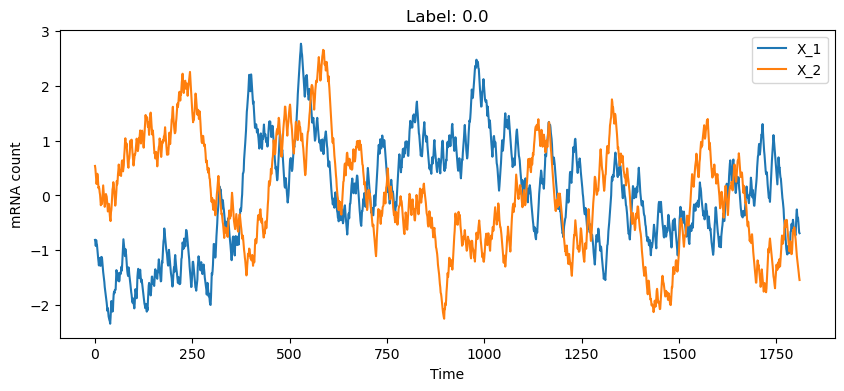

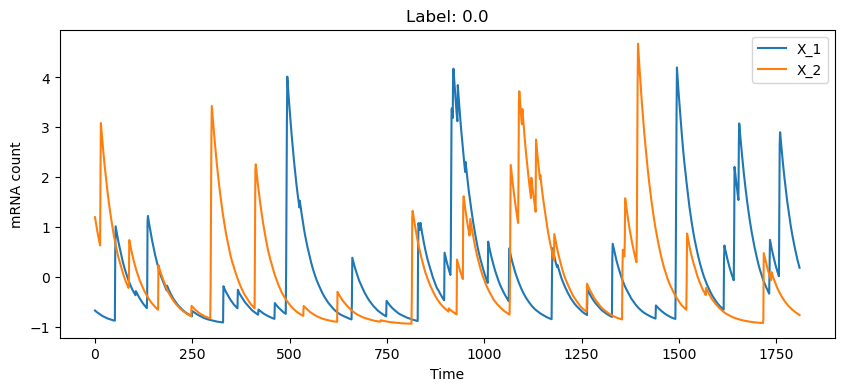

In [4]:
X1_b, X2_b, y_b = next(iter(train_loader))
print(X1_b.shape, X2_b.shape, y_b.shape) # (B, T, 1) (B, T, 1) (B, 1)

# plot the first pair in the batch
plt.figure(figsize=(10,4))
plt.plot(X1_b[0,:,0].numpy(), label='X_1')
plt.plot(X2_b[0,:,0].numpy(), label='X_2')
plt.title(f"Label: {y_b[0].item()}")
plt.xlabel("Time")
plt.ylabel("mRNA count")
plt.legend()
plt.show()

# plot another pair in the batch
plt.figure(figsize=(10,4))
plt.plot(X1_b[1,:,0].numpy(), label='X_1')
plt.plot(X2_b[1,:,0].numpy(), label='X_2')
plt.title(f"Label: {y_b[1].item()}")
plt.xlabel("Time")
plt.ylabel("mRNA count")
plt.legend()
plt.show()

LARS Optimizer (Layer-wise Adaptive Rate Scaling) - may be useful for training with large batch sizes (e.g. 1024)

In [5]:
# # LARS optimizer to be used for SSL
# from torch.optim.optimizer import Optimizer

# class LARS(Optimizer):
#     """
#     LARS Optimizer (Layer-wise Adaptive Rate Scaling)
#     Standard implementation for SimCLR / Self-Supervised Learning.
    
#     Args:
#         params: Model parameters.
#         lr: Base learning rate (SimCLR uses high LR, e.g., 1.0 - 5.0).
#         momentum: Momentum factor (default: 0.9).
#         weight_decay: Weight decay (L2 penalty) (default: 1e-6).
#         trust_coefficient: Trust coefficient for the ratio computation (eta) (default: 0.001).
#         eps: Epsilon to avoid division by zero.
#     """
#     def __init__(self, params, lr=0.1, momentum=0.9, weight_decay=1e-6,
#                  trust_coefficient=0.001, eps=1e-8):
#         defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay,
#                         trust_coefficient=trust_coefficient, eps=eps)
#         super().__init__(params, defaults)

#     @torch.no_grad()
#     def step(self, closure=None):
#         loss = None
#         if closure is not None:
#             with torch.enable_grad():
#                 loss = closure()

#         for group in self.param_groups:
#             weight_decay = group['weight_decay']
#             momentum = group['momentum']
#             lr = group['lr']
#             trust_coeff = group['trust_coefficient']
#             eps = group['eps']

#             for p in group['params']:
#                 if p.grad is None:
#                     continue
                
#                 grad = p.grad
                
#                 # 1. Compute Weight Norm and Grad Norm
#                 p_norm = torch.norm(p.data)
#                 g_norm = torch.norm(grad.data)

#                 # 2. Compute Local Learning Rate (Trust Ratio)
#                 if p_norm != 0 and g_norm != 0:
#                     # LARS Trust Ratio: eta * ||w|| / (||g|| + wd * ||w||)
#                     denominator = g_norm + weight_decay * p_norm
#                     local_lr = trust_coeff * p_norm / (denominator + eps)
                    
#                     # Scale the standard LR by the local trust ratio
#                     actual_lr = lr * local_lr
#                 else:
#                     actual_lr = lr

#                 # 3. Apply Weight Decay to Gradient (Standard SGD-W style)
#                 if weight_decay != 0:
#                     grad = grad.add(p, alpha=weight_decay)

#                 # 4. Apply Momentum
#                 param_state = self.state[p]
#                 if 'momentum_buffer' not in param_state:
#                     buf = param_state['momentum_buffer'] = torch.clone(grad).detach()
#                 else:
#                     buf = param_state['momentum_buffer']
#                     buf.mul_(momentum).add_(grad, alpha=1) # buf = momentum * buf + grad

#                 # 5. Update Weights
#                 # p = p - actual_lr * buf
#                 p.data.add_(buf, alpha=-actual_lr)

#         return loss

# # 2. Separate Parameters (SimCLR Best Practice)
# # We exclude Bias and BatchNorm from LARS adaptation/Weight Decay for stability
# param_weights = []
# param_biases = []

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         if 'bias' in name or 'norm' in name or 'bn' in name:
#             param_biases.append(param)
#         else:
#             param_weights.append(param)

# # 3. Initialize LARS Optimizer OUTSIDE the function
# # SimCLR typically uses a very high LR (e.g., 0.2 to 4.0) with LARS
# optimizer = LARS(
#     [
#         {'params': param_weights, 'weight_decay': 1e-6},
#         {'params': param_biases, 'weight_decay': 0.0, 'trust_coefficient': 1.0} # No decay/adapt for biases
#     ],
#     lr=0.2, # LARS allows higher LRs
#     momentum=0.9,
#     trust_coefficient=0.001
# )


In [6]:
# === Model hyperparams ===
input_size = X1_b.shape[2] 
num_classes = 2
d_model=16
nhead=4
num_layers=2
dropout=0.01
use_conv1d=False 

model = SSL_Transformer(
    input_size=input_size,   
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dropout=dropout,
    use_conv1d=use_conv1d,
)
# === Model hyperparams ===

# === Training hyperparams ===
epochs = 50
patience = 50 // 3 # SSL may benefit from high patience
lr = 1e-2 
optimizer = optim.Adam(model.parameters(), lr=lr)

# Cosine Annealing LR Scheduler (good default for SSL)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# scheduler = None
# 1. simple scheduler choice
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience= patience // 3, factor=0.5) 

# 2. cosine scheduler with warmup, most commonly used for transformer
warmup_steps = int(0.1 * epochs)   # 10% warmup (good default)
from transformers import get_cosine_schedule_with_warmup
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=epochs,
) 

nce_temp = 0.2
loss_fn = InfoNCE(negative_mode='unpaired', temperature=nce_temp)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_clip = None

from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f'IY017_simCLR_b{batch_size}_lr{lr}_L{num_layers}_H{nhead}_D{d_model}_{timestamp}_model.pth'
save_path = model_path
verbose = True

model.to(device)
# === Training hyperparams ===

/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SSL_Transformer(
  (backbone): TransformerClassifier(
    (input_proj): Linear(in_features=1, out_features=16, bias=True)
    (pe): PositionalEncoding()
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=64, bias=True)
          (dropout): Dropout(p=0.01, inplace=False)
          (linear2): Linear(in_features=64, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.01, inplace=False)
          (dropout2): Dropout(p=0.01, inplace=False)
        )
      )
    )
    (dropout): Dropout(p=0.01, inplace=False)
    (head): Linear(in_features=16, out_features=2, bias=True)
  )
  (

In [7]:
# === wandb config (required for tracking within train_model) ===
wandb_config = {
    "entity": "grignard-reagent",
    "project": "IY017-SSL-model",
    "name": f"simCLR_b{batch_size}_lr{lr}_L{num_layers}_H{nhead}_D{d_model}_trj{num_traj}_{timestamp}", # change this to what you want
    "dataset": DATA_ROOT.name,
    "batch_size": batch_size,
    "input_size": input_size,
    "d_model": d_model,
    "nhead": nhead,
    "num_layers": num_layers,
    "num_classes": num_classes,
    "dropout": dropout,
    "use_conv1d": use_conv1d,
    "epochs": epochs,
    "patience": patience,
    "lr": lr,
    "optimizer": type(optimizer).__name__,
    "scheduler": type(scheduler).__name__,
    "loss_fn": type(loss_fn).__name__,
    "model": type(model).__name__,
    "batch_size": train_loader.batch_size,
    "num_traj_per_view": num_traj,
    "sample_len": sample_len,
    "log_scale" : log_scale,
    "instance_norm": instance_norm,
    "model_path": model_path,
    "nce_temp": nce_temp,
    "grad_clip": grad_clip,
}
# === wandb config === 

In [8]:
from training.train import train_ssl_model
history = train_ssl_model(
    model,
    train_loader,
    val_loader,
    epochs=epochs,
    patience=patience,
    lr=lr,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    device=device,
    grad_clip=grad_clip,
    save_path=save_path,
    verbose=verbose,
    wandb_logging=True, # this enables wandb logging within train_model
    wandb_config=wandb_config, # pass the config dictionary
)

wandb: Currently logged in as: grignardreagent (grignard-reagent) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting SSL training...


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 16])

In [8]:
# save the trained model
# torch.save(model.state_dict(), model_path)
# load the trained model
# trained_model_path = f'IY017_simCLR_b64_lr0.01_L2_H4_D16_20260215_163742_model.pth' # batch size 64
# trained_model_path = f'IY017_simCLR_b128_lr0.01_L2_H4_D16_20260217_151037_model.pth' # batch size 128
# trained_model_path = 'IY017_simCLR_b256_lr0.01_L2_H4_D16_20260218_154425_model.pth'
trained_model_path = 'IY017_simCLR_b512_lr0.01_L2_H4_D16_20260219_154043_model.pth'
model.load_state_dict(torch.load(trained_model_path))

<All keys matched successfully>

In [13]:
# clear cuda cache
torch.cuda.empty_cache()

In [10]:
from sklearn.manifold import TSNE
import torch

def plot_ssl_embeddings(model, dataloader, device=None, method='tsne', title="SSL Embeddings"):
    """
    Extracts embeddings from the SSL backbone and visualizes them using t-SNE or PCA.
    
    Parameters:
        model: The trained SSL_Transformer model.
        dataloader: DataLoader containing (X, y) or (x1, x2, y). 
                    Note: For meaningful coloring, 'y' should be the physical class/parameter, 
                    not the SSL pair label.
        device: torch.device.
        method: 'tsne' or 'pca'.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    model.to(device)
    
    embeddings_list = []
    labels_list = []
    
    print(f"Extracting embeddings using {device}...")
    
    with torch.no_grad():
        for batch in dataloader:
            # Handle different DataLoader formats
            if len(batch) == 2:
                # Supervised format: (X, y)
                x, y = batch
            elif len(batch) == 3:
                # SSL format: (x1, x2, y)
                # We only need one view to visualize the space
                x, _, y = batch
            else:
                raise ValueError(f"Unexpected batch structure with length {len(batch)}")

            x = x.to(device)
            
            # --- CRITICAL STEP ---
            # We want the BACKBONE embeddings (h), not the projection (z).
            # The SSL_Transformer stores the TransformerClassifier as 'self.backbone'.
            # We call .encode() to get the [B, D] vector (pooled).
            emb = model.backbone.encode(x)
            
            embeddings_list.append(emb.cpu().numpy())
            labels_list.append(y.numpy().flatten())

    # Concatenate all batches
    X_emb = np.concatenate(embeddings_list, axis=0)
    y_labels = np.concatenate(labels_list, axis=0)
    
    print(f"Embeddings shape: {X_emb.shape}")
    
    # --- Dimensionality Reduction ---
    if method == 'tsne':
        print("Running t-SNE (this may take a moment)...")
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
        X_2d = reducer.fit_transform(X_emb)
    elif method == 'pca':
        print("Running PCA...")
        reducer = PCA(n_components=2)
        X_2d = reducer.fit_transform(X_emb)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")

    # --- Plotting ---
    plt.figure(figsize=(10, 8))
    
    # Use seaborn for easy coloring by label
    # If many unique labels (continuous), use a scatter plot with colorbar
    if len(np.unique(y_labels)) > 20: 
        sc = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_labels, cmap='viridis', alpha=0.6, s=15)
        plt.colorbar(sc, label='Parameter / Label Value')
    else:
        # Categorical labels
        sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_labels, palette='tab10', alpha=0.7, s=20)
    
    plt.title(f"{title} ({method.upper()})")
    plt.xlabel(f"{method.upper()} Dim 1")
    plt.ylabel(f"{method.upper()} Dim 2")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return X_2d, y_labels

See embedding space

Extracting embeddings using cuda...


Embeddings shape: (4928, 16)
Running t-SNE (this may take a moment)...


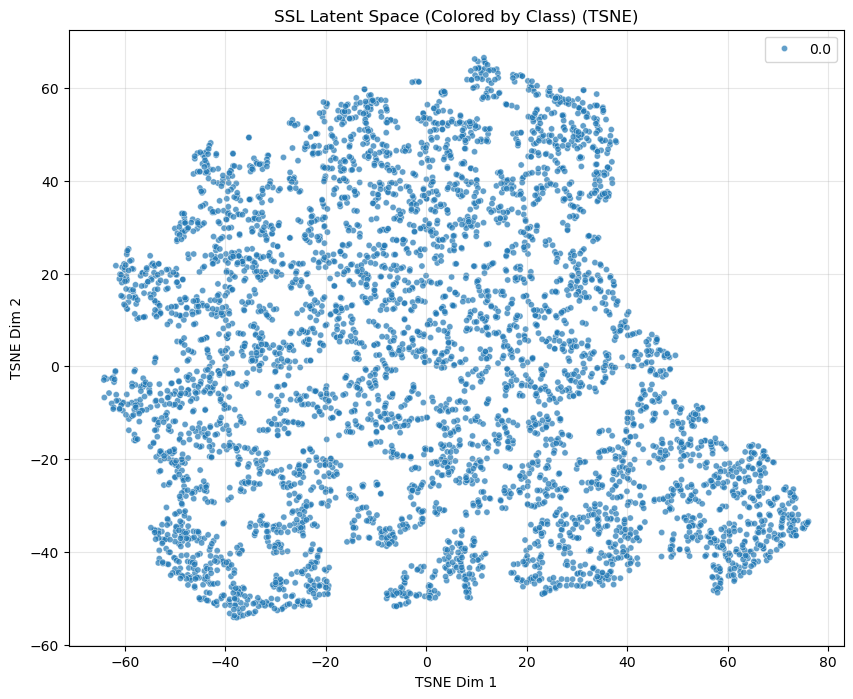

(array([[ 65.97136  , -35.792595 ],
        [ 64.69646  , -39.899395 ],
        [ 19.172646 ,  40.461956 ],
        ...,
        [ 22.047726 ,   8.888686 ],
        [ 56.95316  , -45.40196  ],
        [-55.034245 ,  -5.5604105]], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [11]:
from dataloaders.core import load_and_split_data
from torch.utils.data import TensorDataset, DataLoader
from models.ssl_transformer import SSL_Transformer

# This will pass X through model.backbone.encode() and color by y_test
plot_ssl_embeddings(model, train_loader, device=device, method='tsne', title="SSL Latent Space (Colored by Class)")

Downstream SVM:

Encoder to extract features, then train SVM on those features to predict the parameters. Compare to SVM trained on catch22 features.

In [12]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Import your local modules
from dataloaders.baseline import baseline_data_prep
from models.ssl_transformer import SSL_Transformer

# ==============================================================================
# CONFIGURATION
# ==============================================================================
# Update these paths to match your system
DATA_BASE_DIR = Path("/home/ianyang/stochastic_simulations/experiments/EXP-26-IY020")
MODEL_CHECKPOINT_PATH = trained_model_path

# Model Hyperparameters (MUST MATCH TRAINING)
INPUT_SIZE = input_size
D_MODEL = 16
NHEAD = nhead
NUM_LAYERS = num_layers
DROPOUT = dropout
USE_CONV1D = use_conv1d
DEVICE = device
# ==============================================================================
# HELPER FUNCTIONS
# ==============================================================================

def load_trained_model(checkpoint_path, device):
    """Instantiates the model and loads weights."""
    print(f"Loading model from {checkpoint_path}...")
    model = SSL_Transformer(
        input_size=INPUT_SIZE,
        d_model=D_MODEL,
        nhead=NHEAD,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        use_conv1d=USE_CONV1D
    )
    
    # Load weights
    try:
        state_dict = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"Error loading state dict: {e}")
        print("Tip: If keys don't match, check if you trained with a wrapper or different architecture.")
        raise e
        
    model.to(device)
    model.eval()
    return model

def extract_ssl_features(model, loader, device):
    """
    Extracts features for pairs (x1, x2) using the frozen SSL encoder.
    Feature = |Embed(x1) - Embed(x2)|
    """
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting SSL Features", leave=False):
            # Baseline loader returns X of shape (Batch, Time, 2) and y (Batch, 1)
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            
            # Split the pair into two views
            # X shape is (B, T, 2). Unsqueeze to (B, T, 1) for the model
            x1 = X_batch[:, :, 0].unsqueeze(-1)
            x2 = X_batch[:, :, 1].unsqueeze(-1)
            
            # Get Embeddings
            # Check if model has .encode() (preferred) or use backbone manually
            if hasattr(model, 'encode'):
                z1 = model.encode(x1)
                z2 = model.encode(x2)
            else:
                # Fallback: Forward pass backbone + Mean Pool
                z1 = model.backbone(x1).mean(dim=1)
                z2 = model.backbone(x2).mean(dim=1)
                
            # Compute Interaction Feature: Absolute Difference
            # This turns the verification task into a classification task for SVM
            feat = torch.abs(z1 - z2)
            
            # Ensure 2D shape (Batch, Dim)
            feat_np = feat.cpu().numpy()
            if feat_np.ndim == 1:
                feat_np = feat_np.reshape(-1, 1)
                
            features_list.append(feat_np)
            labels_list.append(y_batch.cpu().numpy())
            
    return np.concatenate(features_list, axis=0), np.concatenate(labels_list, axis=0)

def train_and_evaluate_svm(train_loader, test_loader, model, device, task_name="Task"):
    """
    Pipeline: Extract Features -> Scale -> Train SVM -> Evaluate
    """
    print(f"\n=== Processing {task_name} ===")
    
    # 1. Extract
    print(f"   [1/4] Extracting Train Features...")
    X_train, y_train = extract_ssl_features(model, train_loader, device)
    
    print(f"   [2/4] Extracting Test Features...")
    X_test, y_test = extract_ssl_features(model, test_loader, device)
    
    # 2. Scale
    print(f"   [3/4] Scaling Data...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 3. Train SVM
    print(f"   [4/4] Training SVM & Evaluating...")
    clf = SVC(kernel='rbf', C=1.0)
    clf.fit(X_train_scaled, y_train.ravel())
    
    # 4. Result
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"   >> {task_name} Accuracy: {acc:.2%}")
    return acc

def make_loaders(data_root: Path, results_csv: str):
    """
    Helper to create loaders for a specific dataset folder.
    Replicates the logic from IY016.
    """
    results_path = data_root / results_csv
    if not results_path.exists():
        print(f"Warning: Could not find {results_path}, skipping...")
        return None, None, None

    df_params = pd.read_csv(results_path) 
    # filter out only successful simulations with no error_message, and mean_rel_error_pct < 10, cv_rel_error_pct  < 10, & t_ac_rel_error_pct < 10
    df_params = df_params[(df_params['success'] == True) & 
                        (df_params['error_message'].isna()) &
                        (df_params['mean_rel_error_pct'] < 10) & 
                        (df_params['cv_rel_error_pct'] < 10) & 
                        (df_params['t_ac_rel_error_pct'] < 10)]
    # Construct .npz paths
    traj_paths = [data_root / fname for fname in df_params['trajectory_filename'].values]
    traj_npz_paths = [p.with_suffix('.npz') for p in traj_paths]

    # Use the fixed baseline_data_prep with stack_axis=1
    train_l, val_l, test_l = baseline_data_prep(
        traj_npz_paths,
        batch_size=batch_size,
        num_groups_train=3000, # Same as IY016
        num_groups_test=600,
        num_traj=2,
        pos_ratio=0.5,
        sample_len=500, # Use the length your SSL model expects!
        stack_axis=1,   # Critical for separating channels later
        verbose=False
    )
    return train_l, val_l, test_l

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

if __name__ == "__main__":
    # 1. Load Model
    ssl_model = load_trained_model(MODEL_CHECKPOINT_PATH, DEVICE)

    # 2. Define Experiments (Matching IY016)
    experiments = [
        {
            "name": "Baseline",
            "folder": "data", 
            "csv": "IY020_simulation_parameters_sobol.csv"
        },
        {
            "name": "CV Variation",
            "folder": "data_cv_variation",
            "csv": "IY020_simulation_cv_parameters_sobol.csv"
        },
        {
            "name": "Mu Variation",
            "folder": "data_mu_variation",
            "csv": "IY020_simulation_mu_parameters_sobol.csv"
        },
        {
            "name": "T_ac Variation",
            "folder": "data_t_ac_variation",
            "csv": "IY020_simulation_t_ac_parameters_sobol.csv"
        }
    ]

    results = {}

    # 3. Run Loop
    for exp in experiments:
        data_path = DATA_BASE_DIR / exp["folder"]
        
        # Create Loaders
        train_loader, _, test_loader = make_loaders(data_path, exp["csv"])
        
        if train_loader:
            # Run Evaluation
            acc = train_and_evaluate_svm(train_loader, test_loader, ssl_model, DEVICE, task_name=exp["name"])
            results[exp["name"]] = acc

    # 4. Final Summary
    print("\n" + "="*30)
    print("FINAL RESULTS SUMMARY")
    print("="*30)
    for name, acc in results.items():
        print(f"{name:.<20} {acc:.2%}")

Loading model from IY017_simCLR_b512_lr0.01_L2_H4_D16_20260219_154043_model.pth...

=== Processing Baseline ===
   [1/4] Extracting Train Features...


Extracting SSL Features:   0%|          | 0/47 [00:00<?, ?it/s]

   [2/4] Extracting Test Features...


   [3/4] Scaling Data...
   [4/4] Training SVM & Evaluating...
   >> Baseline Accuracy: 79.00%

=== Processing CV Variation ===
   [1/4] Extracting Train Features...


   [2/4] Extracting Test Features...


   [3/4] Scaling Data...
   [4/4] Training SVM & Evaluating...
   >> CV Variation Accuracy: 71.67%

=== Processing Mu Variation ===
   [1/4] Extracting Train Features...


   [2/4] Extracting Test Features...


   [3/4] Scaling Data...
   [4/4] Training SVM & Evaluating...
   >> Mu Variation Accuracy: 74.17%

=== Processing T_ac Variation ===
   [1/4] Extracting Train Features...


   [2/4] Extracting Test Features...


   [3/4] Scaling Data...
   [4/4] Training SVM & Evaluating...
   >> T_ac Variation Accuracy: 87.17%

FINAL RESULTS SUMMARY
Baseline............ 79.00%
CV Variation........ 71.67%
Mu Variation........ 74.17%
T_ac Variation...... 87.17%
